# Modelos lineares de classificação

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import t as t_dis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize

## Gerando os dados

In [2]:
np.random.seed(42)

n_dogs, n_cats = 500, 500
n = n_dogs + n_cats  # quantidade de exemplos

cov_dogs = 0
cov_cats = 0

dogs = np.random.multivariate_normal(
    [35, 13],
    [
        [4, cov_dogs],
        [cov_dogs, 3]
    ],
    size=n_dogs
)

cats = np.random.multivariate_normal(
    [24, 6],
    [
        [4, cov_cats],
        [cov_cats, 3]
    ],
    size=n_cats
)

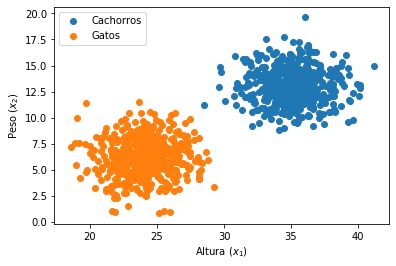

In [3]:
plt.scatter(dogs[:, 0], dogs[:, 1], label='Cachorros')
plt.scatter(cats[:, 0], cats[:, 1], label='Gatos')
plt.xlabel('Altura ($x_1$)')
plt.ylabel('Peso ($x_2$)')
plt.legend()

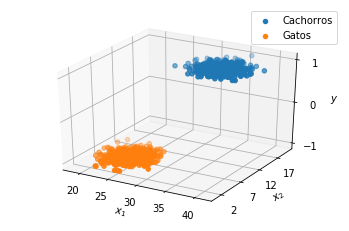

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    dogs[:, 0], dogs[:, 1], np.ones_like(dogs[:, 1]), 
    label='Cachorros'
)
ax.scatter(
    cats[:, 0], cats[:, 1], -1 * np.ones_like(cats[:, 1]), 
    label='Gatos'
)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')
ax.set_zticks([-1, 0, 1])
ax.set_yticks([2, 7, 12, 17])
ax.dist = 11
plt.legend()

## Classificação usando Regressão Linear

In [5]:
X = np.vstack([dogs, cats])
y = np.append(
    np.ones(n_dogs),
    -1 * np.ones(n_cats)
)

lr = LinearRegression().fit(X, y)
print(lr.coef_, lr.intercept_)

[0.11426327 0.08685168] -4.212013204016229


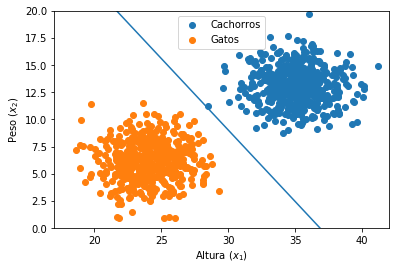

In [6]:
plt.scatter(dogs[:, 0], dogs[:, 1], label='Cachorros')
plt.scatter(cats[:, 0], cats[:, 1], label='Gatos')

x1 = (-1 * lr.intercept_) / lr.coef_[0]
x2 = (-1 * lr.intercept_) / lr.coef_[1]

plt.plot([0, x1], [x2, 0])
plt.xlabel('Altura ($x_1$)')
plt.ylabel('Peso ($x_2$)')
plt.ylim([0, 20])
plt.xlim([17, 42])
plt.legend()

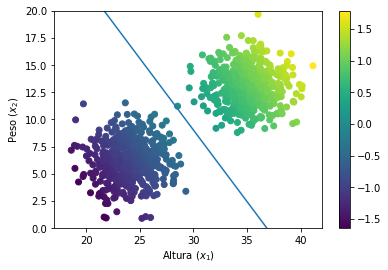

In [7]:
y_hat = lr.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_hat)

x1 = (-1 * lr.intercept_) / lr.coef_[0]
x2 = (-1 * lr.intercept_) / lr.coef_[1]

plt.plot([0, x1], [x2, 0])
plt.xlabel('Altura ($x_1$)')
plt.ylabel('Peso ($x_2$)')
plt.ylim([0, 20])
plt.xlim([17, 42])
plt.colorbar()

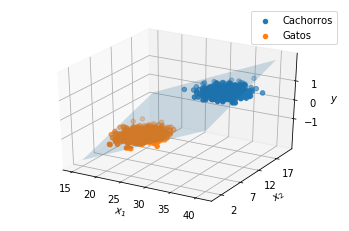

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    dogs[:, 0], dogs[:, 1], np.ones_like(dogs[:, 1]), 
    label='Cachorros'
)
ax.scatter(
    cats[:, 0], cats[:, 1], -1 * np.ones_like(cats[:, 1]), 
    label='Gatos'
)

xx, yy = np.meshgrid(range(15, 41), range(2, 21))

# calculate corresponding z
z = lr.coef_[0] * xx + lr.coef_[1] * yy + lr.intercept_

ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')
ax.set_zticks([-1, 0, 1])
ax.set_yticks([2, 7, 12, 17])
ax.dist = 11
plt.legend()

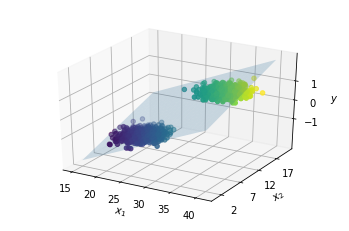

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    X[:, 0], X[:, 1], y, c=y_hat
)

xx, yy = np.meshgrid(range(15, 41), range(2, 21))

# calculate corresponding z
z = lr.coef_[0] * xx + lr.coef_[1] * yy + lr.intercept_

ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')
ax.set_zticks([-1, 0, 1])
ax.set_yticks([2, 7, 12, 17])
ax.dist = 11

## Análise de discriminante linear

In [10]:
def fit_LDA(X, y):
    K = len(np.unique(y))
    N = X.shape[0]
    pi, mu = np.zeros(K), np.zeros((K, X.shape[1]))
    Sigma = np.zeros((X.shape[1], X.shape[1]))
    for k in range(K):
        pi[k] = np.sum(y == k) / N
        Xk = X[y == k]
        mu[k] = np.mean(Xk, axis=0)
        Sigma += (Xk - mu[k]).T @ (Xk - mu[k])
    Sigma = Sigma / (N - K)
    return pi, mu, Sigma

def predict_LDA(X, params):
    (pi, mu, Sigma) = params
    inv = np.linalg.inv(Sigma)
    first_term = np.log(pi[1]/pi[0])
    second_term = -1/2 * (mu[1] + mu[0]) @ inv @ (mu[1] - mu[0]).T
    third_term = X @ inv @ (mu[1] - mu[0]).T
    logit = first_term + second_term + third_term
    return 1. / (1. + np.exp(-logit))

def boundary_LDA(params):
    (pi, mu, Sigma) = params
    inv = np.linalg.inv(Sigma)
    first_term = np.log(pi[1]/pi[0])
    second_term = -1/2 * (mu[1] + mu[0]) @ inv @ (mu[1] - mu[0]).T
    def fun1(x1, args):
        if args[1]:
            X = np.array([[args[0], x1[0]]])
        else:
            X = np.array([[x1[0], args[0]]])
        third_term = X @ inv @ (mu[1] - mu[0]).T
        return (first_term + second_term + third_term) ** 2
    root1 = minimize(fun1, 0, [100, True]).x[0]  
    root2 = minimize(fun1, 0, [100, False]).x[0]      
    
    return (100, root1), (root2, 100)

In [11]:
params = fit_LDA(X, (y + 1)/2)
params

(array([0.5, 0.5]),
 array([[24.12554218,  6.13666121],
        [35.0072024 , 13.06073074]]),
 array([[3.69892204, 0.00649467],
        [0.00649467, 3.09207942]]))

In [12]:
boundary_LDA(params)

((100, -83.06475782461128), (-39.14779205683636, 100))

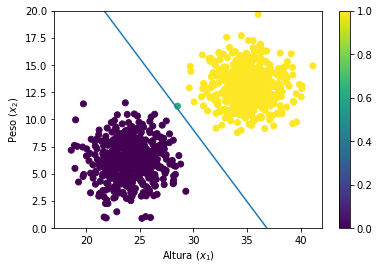

In [13]:
y_hat_LDA = predict_LDA(X, params)
plt.scatter(X[:, 0], X[:, 1], c=y_hat_LDA)

bound_LDA = boundary_LDA(params)

plt.plot(
    [bound_LDA[0][0], bound_LDA[1][0]], 
    [bound_LDA[0][1], bound_LDA[1][1]]
)
plt.xlabel('Altura ($x_1$)')
plt.ylabel('Peso ($x_2$)')
plt.ylim([0, 20])
plt.xlim([17, 42])
plt.colorbar()

## Regressão Logística

In [14]:
def fit_log_reg(X, y):
    N = X.shape[0]
    x = np.hstack((np.ones((N, 1)), X))
    def fun(beta):
        pred = np.clip(
            1. / (1. + np.exp(-(x @ beta.T))), 
            1e-16,
            1 - 1e-16
        )
        return -np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))
    beta_0 = np.random.normal(size=X.shape[1]+1)
    beta = minimize(fun, beta_0).x
    return beta

def predict_log_reg(X, beta):
    N = X.shape[0]
    x = np.hstack((np.ones((N, 1)), X))
    pred = 1. / (1. + np.exp(-(x @ beta.T)))
    return pred

In [15]:
np.random.seed(7)
params_log_reg = fit_log_reg(X, (y + 1)/2)
params_log_reg

array([-1829.71197232,    55.89210549,    22.37151795])

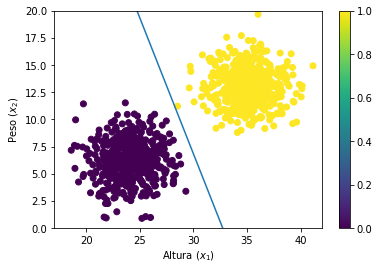

In [16]:
y_hat_log_reg = predict_log_reg(X, params_log_reg)
plt.scatter(X[:, 0], X[:, 1], c=y_hat_log_reg)

inter = params_log_reg[0]
b1 = params_log_reg[1]
b2 = params_log_reg[2]

x1_ = (-1 * inter) / b1
x2_ = (-1 * inter) / b2

plt.plot([0, x1_], [x2_, 0])
plt.xlabel('Altura ($x_1$)')
plt.ylabel('Peso ($x_2$)')
plt.ylim([0, 20])
plt.xlim([17, 42])
plt.colorbar()

### Regressão Logística Regularizada

In [20]:
lr_L2 = LogisticRegression(penalty='l2').fit(X, y)  # sklearn faz L2 por padrão
print(lr_L2.intercept_, lr_L2.coef_)

[-52.25448716] [[1.39914425 1.17444506]]


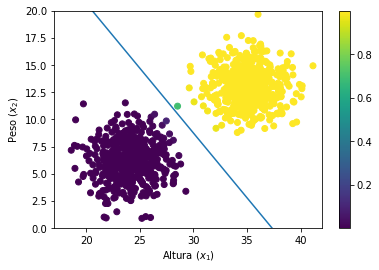

In [23]:
y_hat_lr_L2 = lr_L2.predict_proba(X)[:,1]

plt.scatter(X[:, 0], X[:, 1], c=y_hat_lr_L2)

inter_L2 = lr_L2.intercept_
b1_L2 = lr_L2.coef_[0, 0]
b2_L2 = lr_L2.coef_[0, 1]

x1_L2 = (-1 * inter_L2) / b1_L2
x2_L2 = (-1 * inter_L2) / b2_L2

plt.plot([0, x1_L2], [x2_L2, 0])
plt.xlabel('Altura ($x_1$)')
plt.ylabel('Peso ($x_2$)')
plt.ylim([0, 20])
plt.xlim([17, 42])
plt.colorbar()

## Perceptron

In [24]:
def get_instance(X, y):
    i = 0
    while True:
        yield (X[i], y[i])
        i += 1

In [43]:
def fit_perceptron(X, y):
    rho = 1
    N = X.shape[0]
    
    idx = np.arange(N)  # embaralhando os dados
    np.random.shuffle(idx)
    
    x = np.hstack((np.ones((N, 1)), X[idx]))
    y_ = y[idx]
    
    beta = np.random.normal(size=X.shape[1]+1)
    repeat = True
    while repeat:
        n_misclassified = 0
        for i in range(N):
            value = x[i] @ beta 
            if np.sign(y_[i]) != np.sign(value):
                beta += rho * y_[i] * x[i]
                n_misclassified += 1
        repeat = (n_misclassified > 0)
    return beta.reshape(1, -1)

def predict_perceptron(X, beta):
    N = X.shape[0]
    x = np.hstack((np.ones((N, 1)), X))
    values = x @ beta.T
    return values

In [44]:
np.random.seed(7)
params_per = fit_perceptron(X, y)
params_per

array([[-2289.19440607,    36.70080277,   122.0765935 ]])

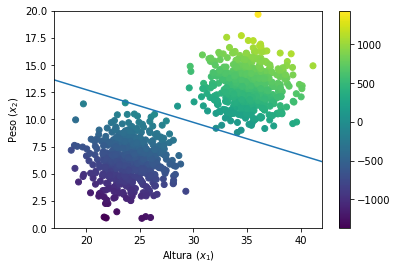

In [48]:
y_hat_per = predict_perceptron(X, params_per)
plt.scatter(X[:, 0], X[:, 1], c=y_hat_per.flatten())

inter_per = params_per[0, 0]
b1_per = params_per[0, 1]
b2_per = params_per[0, 2]

x1_per = (-1 * inter_per) / b1_per
x2_per = (-1 * inter_per) / b2_per

plt.plot([0, x1_per], [x2_per, 0])
plt.xlabel('Altura ($x_1$)')
plt.ylabel('Peso ($x_2$)')
plt.ylim([0, 20])
plt.xlim([17, 42])
plt.colorbar()

## Todas as fronteiras

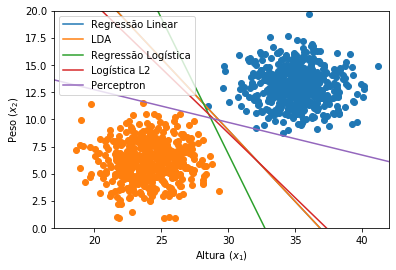

In [50]:
plt.scatter(dogs[:, 0], dogs[:, 1])
plt.scatter(cats[:, 0], cats[:, 1])

x1 = (-1 * lr.intercept_) / lr.coef_[0]
x2 = (-1 * lr.intercept_) / lr.coef_[1]

plt.plot([0, x1], [x2, 0], label='Regressão Linear')

plt.plot(
    [bound_LDA[0][0], bound_LDA[1][0]], 
    [bound_LDA[0][1], bound_LDA[1][1]],
    label='LDA'
)
plt.plot([0, x1_], [x2_, 0], label='Regressão Logística')
plt.plot([0, x1_L2], [x2_L2, 0], label='Logística L2')
plt.plot([0, x1_per], [x2_per, 0], label='Perceptron')
plt.xlabel('Altura ($x_1$)')
plt.ylabel('Peso ($x_2$)')
plt.ylim([0, 20])
plt.xlim([17, 42])
plt.legend()